In [1]:
# Task 2: Sentiment and Thematic Analysis

# Description: Sentiment scoring (DistilBERT) + Keyword Extraction + Thematic Grouping

# 📦 Install dependencies if not already installed
!pip install transformers scikit-learn spacy nltk --quiet
!python -m nltk.downloader stopwords
!python -m spacy download en_core_web_sm


<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import re
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline

# Load spaCy and NLTK
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))


In [4]:
from google.colab import files
uploaded = files.upload()

Saving cleaned_reviews.csv to cleaned_reviews.csv


In [5]:
filename = list(uploaded.keys())[0]

# Read into a DataFrame
df = pd.read_csv(filename)

# Preview
df.head()

,review,rating,date,bank,source
0,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play
1,I cannot send to cbebirr app. through this app.,3,2025-06-05,Commercial Bank of Ethiopia,Google Play
2,good,4,2025-06-05,Commercial Bank of Ethiopia,Google Play
3,not functional,1,2025-06-04,Commercial Bank of Ethiopia,Google Play
4,everytime you uninstall the app you have to re...,1,2025-06-04,Commercial Bank of Ethiopia,Google Play


In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

def preprocess_text(text):
    text = clean_text(text)
    doc = nlp(text)
    return " ".join(
        [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct and not token.is_space]
    )


In [7]:
df

,review,rating,date,bank,source
0,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play
1,I cannot send to cbebirr app. through this app.,3,2025-06-05,Commercial Bank of Ethiopia,Google Play
2,good,4,2025-06-05,Commercial Bank of Ethiopia,Google Play
3,not functional,1,2025-06-04,Commercial Bank of Ethiopia,Google Play
4,everytime you uninstall the app you have to re...,1,2025-06-04,Commercial Bank of Ethiopia,Google Play
...,...,...,...,...,...
1420,Best,5,2025-01-13,Dashen Bank,Google Play
1421,"Waw Great and innovated,user friendly, always ...",5,2025-01-13,Dashen Bank,Google Play
1422,It's Best waww 🙏,5,2025-01-12,Dashen Bank,Google Play
1423,Always one step ahead,5,2025-01-12,Dashen Bank,Google Play


In [8]:
# Load HuggingFace sentiment classifier
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Clean and score each review
df['cleaned_text'] = df['review'].astype(str).apply(preprocess_text)
df['sentiment'] = df['cleaned_text'].apply(lambda x: classifier(x)[0]['label'])
df['sentiment_score'] = df['cleaned_text'].apply(lambda x: classifier(x)[0]['score'])

# Optional: map labels to lowercase
df['sentiment_label'] = df['sentiment'].map({'POSITIVE': 'positive', 'NEGATIVE': 'negative'})


Device set to use cpu


In [9]:
# Use TF-IDF to extract top 1-2 word phrases (bigrams)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
X = vectorizer.fit_transform(df['cleaned_text'])

# View top terms
top_keywords = vectorizer.get_feature_names_out()
print("Top keywords:", top_keywords[:20])


Top keywords: ['access' 'account' 'ahead' 'also' 'always' 'amazing' 'app' 'app ever'
 'app not' 'application' 'bad' 'bad app' 'bank' 'bank super' 'banking'
 'banking app' 'boa' 'can' 'can not' 'cbe']


In [10]:
# Define keyword groupings for each theme
theme_map = {
    "Account Access Issues": ["login", "signin", "password", "register"],
    "Transaction Performance": ["transfer", "fail", "delay", "error", "crash"],
    "User Interface & Experience": ["ui", "interface", "design", "easy", "navigation"],
    "Customer Support": ["support", "help", "contact", "response"],
    "Feature Requests": ["option", "feature", "add", "notification", "update"]
}

def assign_theme(text):
    found_themes = set()
    for theme, keywords in theme_map.items():
        if any(keyword in text for keyword in keywords):
            found_themes.add(theme)
    return list(found_themes) if found_themes else ["Other"]

df['themes'] = df['cleaned_text'].apply(assign_theme)


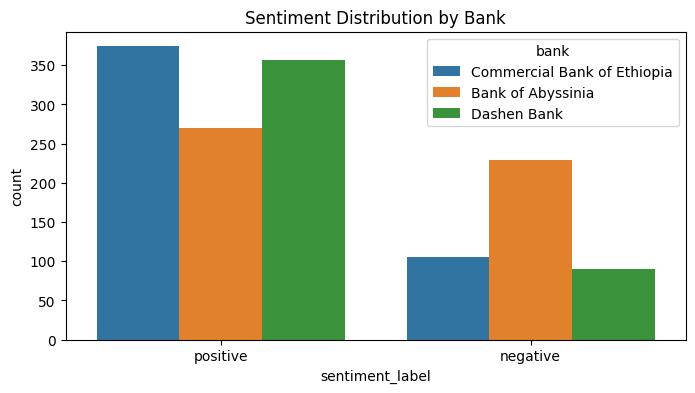

In [15]:
# ✅ STEP 9: (Optional) Plot Sentiment Distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='sentiment_label', hue='bank')
plt.title("Sentiment Distribution by Bank")
plt.show()


In [13]:
df[df['sentiment_label']=='positive']

,review,rating,date,bank,source,cleaned_text,sentiment,sentiment_score,sentiment_label,themes
0,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play,app proactive good connection,POSITIVE,0.999832,positive,[Other]
2,good,4,2025-06-05,Commercial Bank of Ethiopia,Google Play,good,POSITIVE,0.999816,positive,[Other]
3,not functional,1,2025-06-04,Commercial Bank of Ethiopia,Google Play,functional,POSITIVE,0.999333,positive,[Other]
5,አካውንት የምናስገባበት ቦታ ስም ጽፈን ነው ከዚህ በፊት የላክንባቸውን አ...,4,2025-06-04,Commercial Bank of Ethiopia,Google Play,mr space,POSITIVE,0.991881,positive,[Other]
6,best,5,2025-06-04,Commercial Bank of Ethiopia,Google Play,well,POSITIVE,0.999570,positive,[Other]
...,...,...,...,...,...,...,...,...,...,...
1420,Best,5,2025-01-13,Dashen Bank,Google Play,well,POSITIVE,0.999570,positive,[Other]
1421,"Waw Great and innovated,user friendly, always ...",5,2025-01-13,Dashen Bank,Google Play,waw great innovateduser friendly always one st...,POSITIVE,0.999627,positive,[Other]
1422,It's Best waww 🙏,5,2025-01-12,Dashen Bank,Google Play,good waww,POSITIVE,0.999860,positive,[Other]
1423,Always one step ahead,5,2025-01-12,Dashen Bank,Google Play,always one step ahead,POSITIVE,0.999770,positive,[Other]


In [16]:
# Save DataFrame to CSV
df.to_csv("task2_sentiment_analysis.csv", index=False)


In [17]:
from google.colab import files
files.download("task2_sentiment_analysis.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>